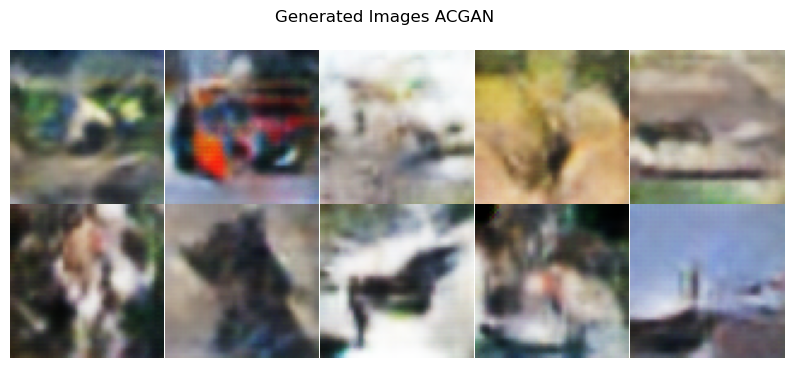

10 generated images saved as 'generated_images_acgan.png'


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.utils import save_image

# Generator Model (same as in the original code)
class ACGAN_Generator(nn.Module):
    def __init__(self, noise_dim, class_dim, img_channels):
        super(ACGAN_Generator, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(class_dim, 256),
            nn.ReLU(inplace=True)
        )
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 256, 4 * 4 * 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.embedding(labels)
        noise = noise.view(noise.size(0), -1)
        merged_input = torch.cat((noise, label_embed), dim=1)
        return self.model(merged_input)

# Parameters
NOISE_DIM = 100
CLASS_DIM = 10
IMG_CHANNELS = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
generator = ACGAN_Generator(NOISE_DIM, CLASS_DIM, IMG_CHANNELS).to(device)
generator.load_state_dict(torch.load("models/generator_epoch_100.pth"))
generator.eval()

# Generate 10 images
def generate_images(generator, num_images=10):
    noise = torch.randn(num_images, NOISE_DIM, device=device)
    conditions = torch.eye(CLASS_DIM, device=device)[:num_images]  # One-hot encoded labels
    fake_images = generator(noise, conditions)
    fake_images = (fake_images + 1) / 2  # Scale to [0, 1] for visualization

    # Display the images without gaps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4), gridspec_kw={'wspace': 0, 'hspace': 0})
    grid = fake_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    for i, ax in enumerate(axes.flat):
        ax.imshow(grid[i])
        ax.axis("off")  # Remove axis
    plt.suptitle("Generated Images ACGAN")
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove gaps
    plt.savefig("generated_images_acgan.png", bbox_inches='tight', pad_inches=0)
    plt.show()

    print("10 generated images saved as 'generated_images_acgan.png'")

# Generate and save images
generate_images(generator)

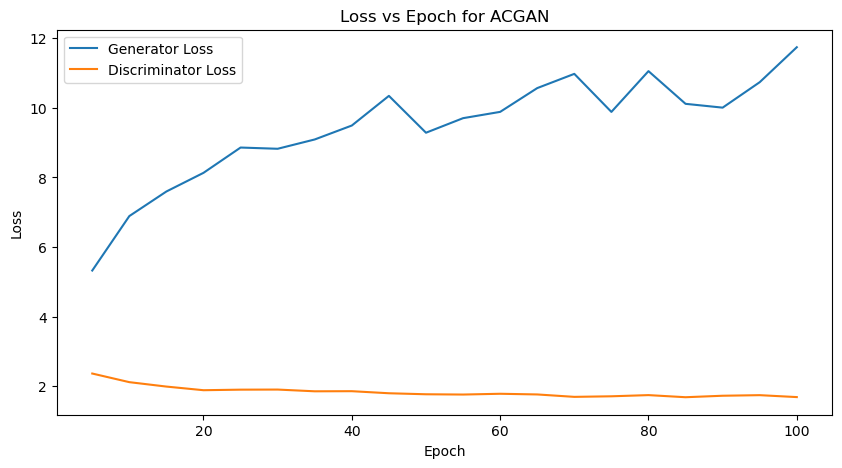

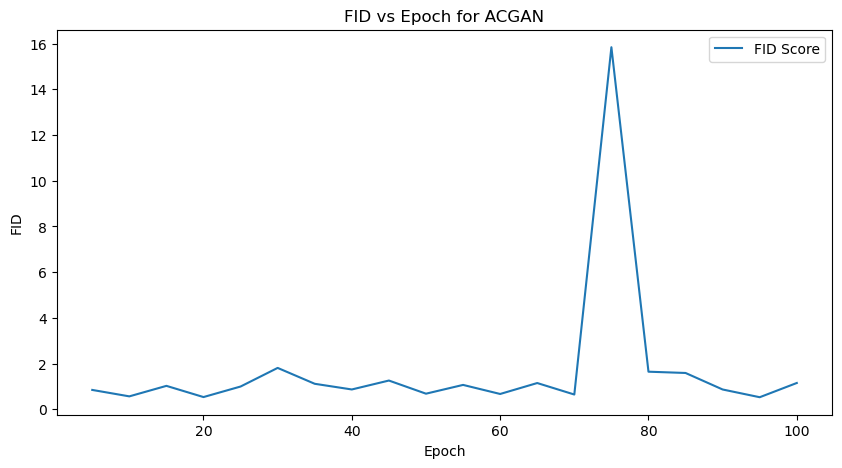

Loss and FID plots saved as 'loss_vs_epoch_acgan.png' and 'fid_vs_epoch_acgan.png'


In [3]:
# Plot Loss vs Epoch and FID vs Epoch
def plot_metrics(log_file):
    # Load the log file
    df = pd.read_csv(log_file)

    # Plot Loss vs Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Generator Loss'], label="Generator Loss")
    plt.plot(df['Epoch'], df['Discriminator Loss'], label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch for ACGAN")
    plt.legend()
    plt.savefig("loss_vs_epoch_acgan.png")
    plt.show()

    # Plot FID vs Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['FID Score'], label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID vs Epoch for ACGAN")
    plt.legend()
    plt.savefig("fid_vs_epoch_acgan.png")
    plt.show()

    print("Loss and FID plots saved as 'loss_vs_epoch_acgan.png' and 'fid_vs_epoch_acgan.png'")

# Plot metrics
plot_metrics("logs/training_log.csv")